# Taxi drivers: How to earn money more efficiently?
### The taxi rides in Chicago (2016)
This dataset includes taxi trips for 2016, reported to the City of Chicago in its role as a regulatory agency. Here, a subset of january data is analyzed in this notebook as a trial analysis. A direct question from this dataset that interests taxi driver is that what type of ride tends to have more earning? However, it basically depends on the taxi fare policy in Chicago. Another question more interesting is that **how to earn money more efficiently (i.e. higher fare / working time) for a taxi driver as an individual**. To answer this question, I grouped the dataset by taxi_id and generated new features for each driver, such as total rides, total working time (including the gap between billed trips), mean trip mile, most active community area, most active hour in the day, most active weekday and etc. A random forest regression model is applied to predict the working efficiency with a R^2 = 0.8534.

Data source: https://www.kaggle.com/chicago/chicago-taxi-rides-2016

Original data source: http://digital.cityofchicago.org/index.php/chicago-taxi-data-released

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pickle
import datetime
from __future__ import division
% matplotlib inline

In [588]:
january = pd.read_csv('~\Downloads\chicago_taxi\chicago_taxi_trips_2016_01.csv', 
                      parse_dates=['trip_start_timestamp', 'trip_end_timestamp'])

In [589]:
january.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705805 entries, 0 to 1705804
Data columns (total 20 columns):
taxi_id                   float64
trip_start_timestamp      datetime64[ns]
trip_end_timestamp        datetime64[ns]
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type              object
company                   float64
pickup_latitude           float64
pickup_longitude          float64
dropoff_latitude          float64
dropoff_longitude         float64
dtypes: datetime64[ns](2), float64(17), object(1)
memory usage: 260.3+ MB


## Impute missing values

pickup_census_tract       1.000000
dropoff_census_tract      0.432831
company                   0.370925
dropoff_community_area    0.183875
dropoff_longitude         0.182718
dropoff_latitude          0.182718
pickup_community_area     0.167539
pickup_longitude          0.167520
pickup_latitude           0.167520
trip_seconds              0.000184
trip_end_timestamp        0.000073
fare                      0.000019
tips                      0.000019
tolls                     0.000019
extras                    0.000019
trip_total                0.000019
taxi_id                   0.000013
trip_miles                0.000008
payment_type              0.000000
trip_start_timestamp      0.000000
dtype: float64


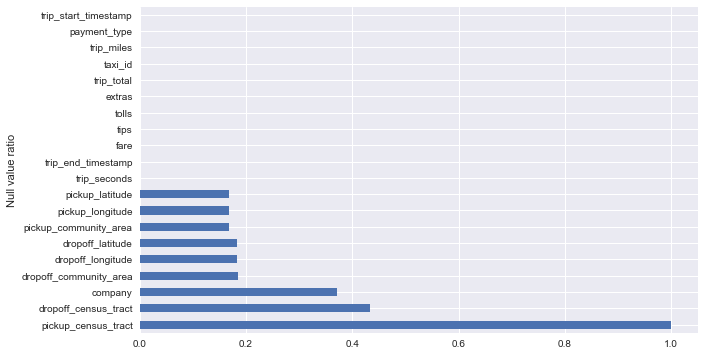

In [540]:
# Nan value distribution
nrow = january.shape[0]
nans = january.isnull().sum()/nrow
nans = nans.sort_values(ascending=False)
print(nans)
fig, ax = plt.subplots(figsize = (10, 6))
nans.plot.barh()
plt.ylabel('Null value ratio')
plt.show()

In [541]:
# Drop columns with nan value proportion more than 40% 
january.drop(['pickup_census_tract', 'dropoff_census_tract'], axis=1, inplace=True)
# Drop rows (few) which contains nan value
january = january.dropna(subset=['trip_end_timestamp', 'fare', 'trip_seconds', 'taxi_id', 'trip_miles'])

In [7]:
def fillna_mean(df, col):
    # fillna cols in the list with col mean
    for c in col:
        mean = df[col].mean()
        df[col] = df[col].fillna(mean)

col_fillna_mean = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
fillna_mean(january, col_fillna_mean)
# fillna with -1 for the company column
january['company'] = january['company'].fillna(-1)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

def fillna_community_area(df, col1, col2, col3):
    # Fill the nan value in community area based on their closest neighbors by the latitude and longitude 
    model = KNeighborsClassifier(n_neighbors=32)
    X = df.loc[~df[col3].isnull(), [col1, col2]]
    Y = df.loc[~df[col3].isnull(), col3]
    model.fit(X, Y)
    testx = df.loc[df[col3].isnull(), [col1, col2]]
    df.loc[df[col3].isnull(), col3] = model.predict(testx)
    
fillna_community_area(january, 'pickup_latitude', 'pickup_longitude', 'pickup_community_area')
fillna_community_area(january, 'dropoff_latitude', 'dropoff_longitude', 'dropoff_community_area')

In [12]:
january.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-01-13 06:15:00,2016-01-13 06:15:00,180.0,0.40,24.0,24.0,4.50,0.00,0.0,0.0,4.50,Cash,107.0,199.000000,510.000000,199.000000,510.000000
1,2776.0,2016-01-22 09:30:00,2016-01-22 09:45:00,240.0,0.70,28.0,28.0,4.45,4.45,0.0,0.0,8.90,Credit Card,-1.0,392.134575,437.780047,401.296905,438.859253
2,3168.0,2016-01-31 21:30:00,2016-01-31 21:30:00,0.0,0.00,28.0,28.0,42.75,5.00,0.0,0.0,47.75,Credit Card,119.0,392.134575,437.780047,401.296905,438.859253
3,4237.0,2016-01-23 17:30:00,2016-01-23 17:30:00,480.0,1.10,6.0,6.0,7.00,0.00,0.0,0.0,7.00,Cash,-1.0,686.000000,500.000000,686.000000,500.000000
4,5710.0,2016-01-14 05:45:00,2016-01-14 06:00:00,480.0,2.71,32.0,28.0,10.25,0.00,0.0,0.0,10.25,Cash,-1.0,385.000000,478.000000,401.296905,438.859253


In [26]:
import pickle
# pickle precleaned dataset for future use 
january.to_pickle('201610')

In [544]:
jan = pd.read_pickle('201610')
nrow = jan.shape[0]
print(nrow)

1705421


# Remove outlier and unreasonable entries

In [547]:
tip_pay = pd.DataFrame([jan['tips'] == 0, jan['payment_type'] == 'Cash'])
tip_pay = tip_pay.T
tip_pay.corr()

,tips,payment_type
tips,1.000000,0.949045
payment_type,0.949045,1.000000


The correlation matrix above indicates the payment_type (cash or credit card) is highly correlated with the result if tips is given. According to our real-life experience, it is probable that the tips given by cash is not recorded. Therefore, fare is used instead of trip total, to reflect more the reality.

In [545]:
# unreasonable: trip_seconds == 0 but earned more than base fare
print(((jan['trip_seconds'] == 0) & (jan['fare'] > 3.25)).sum())
jan = jan.drop(jan.index[(jan['trip_seconds'] == 0) & (jan['fare'] > 3.25)])
print(jan.shape)

144778
(1560643, 18)


In [546]:
# unreasonable: average speed trip_miles/ trip_seconds > 0.05 (180 mile/h)
print((jan.loc[jan['trip_seconds'] > 0, 'trip_miles'] / jan.loc[jan['trip_seconds'] > 0, 'trip_seconds']).describe())
print(((jan.loc[jan['trip_seconds'] > 0, 'trip_miles'] / jan.loc[jan['trip_seconds'] > 0, 'trip_seconds']) > 0.05).sum())
jan = jan.drop(jan.index[((jan['trip_seconds'] > 0) & ((jan['trip_miles'] / jan['trip_seconds']) > 0.05))])
print(jan.shape)

count    1.517119e+06
mean     3.632968e-03
std      1.902107e-02
min      0.000000e+00
25%      6.250000e-04
50%      2.857143e-03
75%      4.375000e-03
max      1.419000e+01
dtype: float64
1443
(1559200, 18)


In [550]:
# unreasonable: charge much more than the Chicago taxi policy
# example: id: 7486, charge $85.00 fare with 3 min and 0 trip mile
print((jan['fare'] > 3.25 + 2 * (jan['trip_miles'] + 0.5) + 0.05 * jan['trip_seconds']).sum())
jan = jan.drop(jan.index[jan['fare'] > (3.25 + 2 * (jan['trip_miles'] + 0.5) + 0.05 * jan['trip_seconds'])])
print(jan.shape)

1312
(1557888, 18)


In [551]:
# unreasonable: no fare with either positive trip time or trip mile
print(((jan['fare'] == 0) & ((jan['trip_miles'] > 0) | (jan['trip_seconds'] > 0))).sum())
jan = jan.drop(jan.index[(jan['fare'] == 0) & ((jan['trip_miles'] > 0) | (jan['trip_seconds'] > 0))])
print(jan.shape)

1532
(1556356, 18)


# Feature Engineering

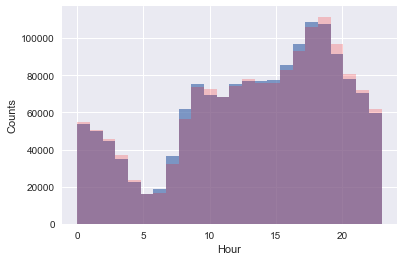

In [552]:
jan['start_hour'] = jan['trip_start_timestamp'].dt.hour
jan['end_hour'] = jan['trip_end_timestamp'].dt.hour
jan['start_hour'].hist(alpha = 0.7, label=['pickup'], bins=24)
jan['end_hour'].hist(alpha = 0.2, label=['dropoff'], color='red', bins=24)
plt.xlabel('Hour')
plt.ylabel('Counts')
plt.show()

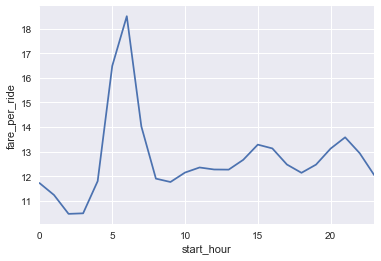

In [553]:
jan.groupby('start_hour')['fare'].mean().plot()
plt.ylabel('fare_per_ride')
plt.show()

[]

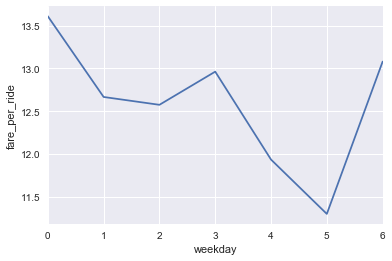

In [558]:
jan['weekday'] = jan['trip_start_timestamp'].dt.weekday
jan.groupby('weekday')['fare'].mean().plot()
plt.ylabel('fare_per_ride')
plt.plot()

In [554]:
jan['trip_seconds'].describe()

count    1.556356e+06
mean     7.113685e+02
std      8.661501e+02
min      0.000000e+00
25%      3.000000e+02
50%      5.400000e+02
75%      8.400000e+02
max      8.634000e+04
Name: trip_seconds, dtype: float64

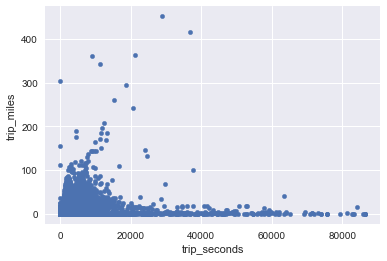

In [555]:
jan.plot.scatter(x = 'trip_seconds', y = 'trip_miles')
plt.show()

In [557]:
# Rount contains both pickup_community_area and dropoff_community_area
jan['route'] = jan['pickup_community_area'].astype(int).astype(str) + '_' + jan['dropoff_community_area'].astype(int).astype(str)

# Analyze taxi driver as an individual (groupby taxi_id) and create new features from those of rides

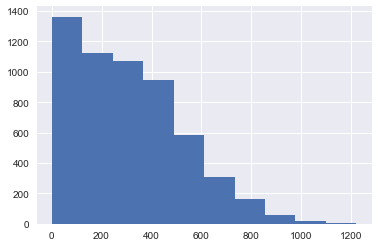

In [38]:
jan['taxi_id'].value_counts().hist()

count     4600.00000
mean      4232.04665
std       2540.52552
min          0.00000
25%       2716.67500
50%       4504.66000
75%       5862.56250
max      13700.93000
Name: fare, dtype: float64


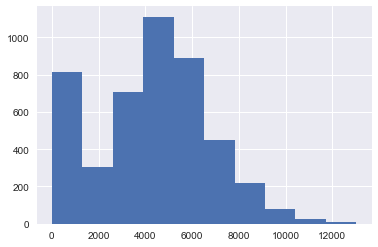

In [559]:
taxi_id = jan.groupby('taxi_id')
# Total fare earned by each taxi driver in Jan 2016
print(taxi_id['fare'].sum().describe())
taxi_id['fare'].sum().sort_values(ascending=False).iloc[1:].hist()
plt.show()

In [560]:
# Create new df, recording taxi driver information
taxi_id2 = pd.DataFrame()
# Total fare earned by each taxi driver in Jan 2016
taxi_id2['total_fare'] = taxi_id['fare'].sum()
# Drop outlier (unreasonable earning)
taxi_id2 = taxi_id2.drop(np.argmax(taxi_id['fare'].sum()))
# Get company
taxi_id2['company'] = taxi_id['company'].agg(lambda x: x.value_counts().index[0])

In [183]:
jan[['taxi_id', 'company']].corr()

,taxi_id,company
taxi_id,1.000000,-0.016632
company,-0.016632,1.000000


In [297]:
taxi_id2['company'].value_counts()

-1.0      1661
 107.0    1141
 119.0     464
 101.0     343
 109.0     266
 8.0       245
 90.0      143
 82.0      112
 10.0       75
 92.0       55
 68.0       46
 43.0       16
 3.0         9
 20.0        2
 91.0        1
 97.0        1
 9.0         1
 14.0        1
 80.0        1
 2.0         1
 12.0        1
 28.0        1
 15.0        1
 44.0        1
 72.0        1
 6.0         1
 5.0         1
 26.0        1
 99.0        1
 35.0        1
 21.0        1
 118.0       1
 106.0       1
 65.0        1
 63.0        1
 37.0        1
 111.0       1
 89.0        1
 79.0        1
 42.0        1
 57.0        1
 102.0       1
 31.0        1
 115.0       1
 17.0        1
 103.0       1
 73.0        1
 74.0        1
 55.0        1
 75.0        1
Name: company, dtype: int64

In [561]:
company_ct = taxi_id2['company'].value_counts() 
def group_company(x):
    if company_ct[x] < 50:
        return 0
    elif company_ct[x] < 150:
        return 1
    elif company_ct[x] < 1000:
        return 2
    elif company_ct[x] < 1500:
        return 3
    else:
        return x
taxi_id2['company'] = taxi_id2['company'].apply(lambda x: group_company(x))

In [562]:
# new features
taxi_id2['total_trip_time'] = taxi_id['trip_seconds'].sum()
taxi_id2['mean_trip_time'] = taxi_id['trip_seconds'].mean()
taxi_id2['trip_time_std'] = taxi_id['trip_seconds'].std()
taxi_id2['total_mile'] = taxi_id['trip_miles'].sum()
taxi_id2['mile_mean'] = taxi_id['trip_miles'].mean()
taxi_id2['mile_std'] = taxi_id['trip_miles'].std()
# total ride number
taxi_id2['trip_num'] = taxi_id.size()
# most probable hour to pickup
taxi_id2['max_hour'] = taxi_id['start_hour'].agg(lambda x: x.value_counts().index[0])
# least probable hour to pickup
taxi_id2['min_hour'] = taxi_id['start_hour'].agg(lambda x: x.value_counts().index[-1])
# most probable community area to pickup
taxi_id2['max_pickup_community'] = taxi_id['pickup_community_area'].agg(lambda x: x.value_counts().index[0])
# most probable community area to dropoff
taxi_id2['max_dropoff_community'] = taxi_id['dropoff_community_area'].agg(lambda x: x.value_counts().index[0])
# most probable route
taxi_id2['max_route'] = taxi_id['route'].agg(lambda x: x.value_counts().index[0])
# most probable weekday to pickup
taxi_id2['max_weekday'] = taxi_id['weekday'].agg(lambda x: x.value_counts().index[0])
# least probable weekday to pickup
taxi_id2['min_weekday'] = taxi_id['weekday'].agg(lambda x: x.value_counts().index[-1])

In [563]:
import datetime
def get_min(time_diff):
    return (time_diff.days * 1440 + time_diff.seconds // 60)

def get_work_time(x, first_date, last_date, total_min):
    # Calculate the real working time, assuming that drivers are not working for gap between trips > 2 hours 
    if x.shape[0] < 1:
        return 0    
    time_seq = x.sort_values(by = 'trip_start_timestamp')
    time_seq.reset_index(drop=True, inplace=True)
    nrow = time_seq.shape[0]
    if x.shape[0] == 1:
        return get_min(time_seq.loc[0, 'trip_end_timestamp'] - time_seq.loc[0, 'trip_start_timestamp'])
    before_work = get_min(time_seq.loc[0, 'trip_start_timestamp'] - first_date)
    after_work = get_min(last_date - time_seq.loc[nrow-1, 'trip_end_timestamp'])
    time_gap = time_seq['trip_start_timestamp'].shift(-1) - time_seq['trip_end_timestamp']
    time_in_min = time_gap[(time_seq['trip_start_timestamp'].shift(-1) > time_seq['trip_end_timestamp'])].apply(lambda x: get_min(x))
    time_in_min[-1] = 0
    total_rest = time_in_min[(time_in_min> 120)].sum()
    return (total_min - total_rest - before_work - after_work)

first_date = datetime.datetime.strptime('201601010000', "%Y%m%d%H%M")
last_date = datetime.datetime.strptime('201601312359', "%Y%m%d%H%M")
total_min = get_min(last_date - first_date)
print(total_min)
taxi_id2['work_time'] = taxi_id[['trip_start_timestamp', 'trip_end_timestamp']].\
                        apply(lambda x: get_work_time(x, first_date, last_date, total_min))


44639


In [564]:
# To get a generalized conclusion, drivers working less than 24 hours per month is excluded 
taxi_id2 = taxi_id2.drop(taxi_id2.index[taxi_id2['work_time'] < 1440])
taxi_id2['trip_time_ratio'] = taxi_id2['total_trip_time'] / taxi_id2['work_time']
taxi_id2['fare_per_min'] = taxi_id2['total_fare'] / taxi_id2['work_time']
# Remove outlier
taxi_id2 = taxi_id2.drop(taxi_id2.index[taxi_id2['fare_per_min'] > 1.25])

In [618]:
taxi_id2.to_pickle('201610_taxi')

# Data Visualizaiton

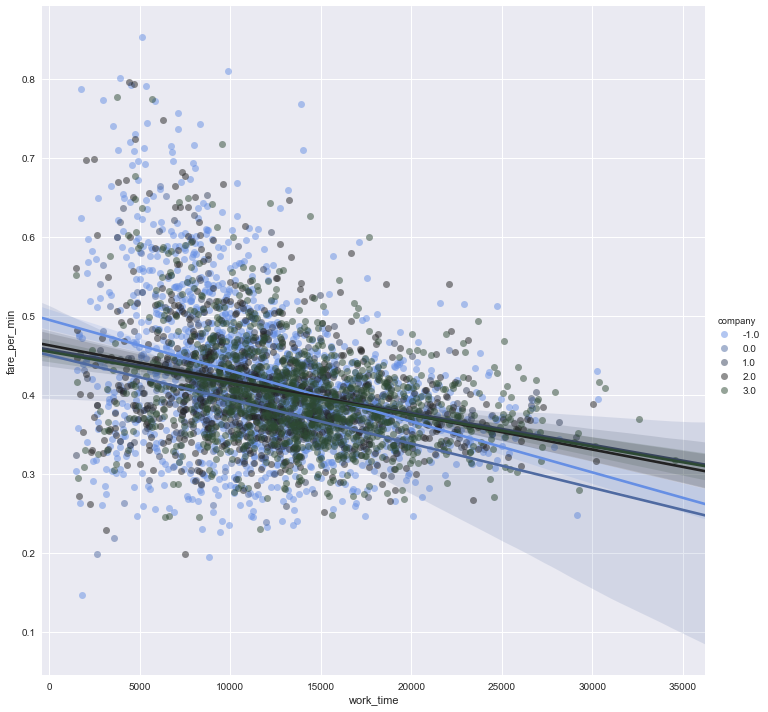

In [566]:
# Is taxi driver working longer more effective? No.
sns.lmplot(data=taxi_id2, x = 'work_time', y = 'fare_per_min', fit_reg = True, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(255, 133, l=60, n=7, center="dark"))
plt.show()

In [619]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

output_file("toolbar.html")
colormap = {-1: 'gray', 0: 'whitesmoke', 1: 'bisque', 2: 'aliceblue', 3: 'olivedrab'}
df = taxi_id2['company'].map(lambda x: colormap[x])

source = ColumnDataSource(data=dict(
    x=taxi_id2['trip_time_ratio'],
    y=taxi_id2['fare_per_min'],
    company=taxi_id2['company'],
))

hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("company", "@company"),
])


p = figure(plot_width=800, plot_height=800, tools=[hover, 'pan, box_zoom, reset'],
           x_axis_label='Ratio of trip time to work time', y_axis_label = 'Fare per minute')

p.circle('x', 'y', size=5, source=source,
          color=df, fill_alpha=0.2)

show(p)

Loading BokehJS ...

C:\Users\gofys\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\gofys\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


In [598]:
taxi_id2['fare_per_min'] = fare_per_min

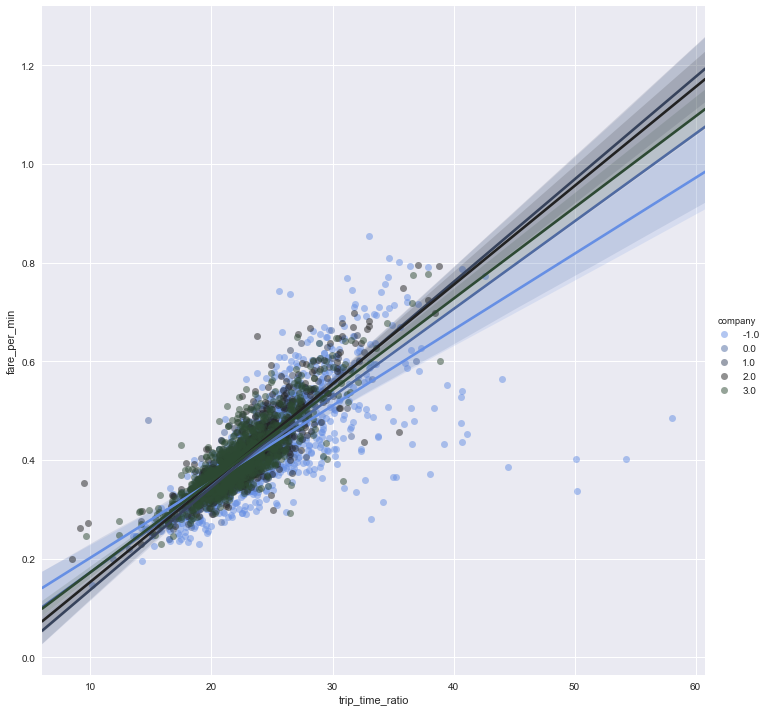

In [583]:
# Do you drive a lot to find a passenger?
sns.lmplot(data=taxi_id2, x = 'trip_time_ratio', y = 'fare_per_min', fit_reg = True, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(255, 133, l=60, n=7, center="dark"))
plt.show()

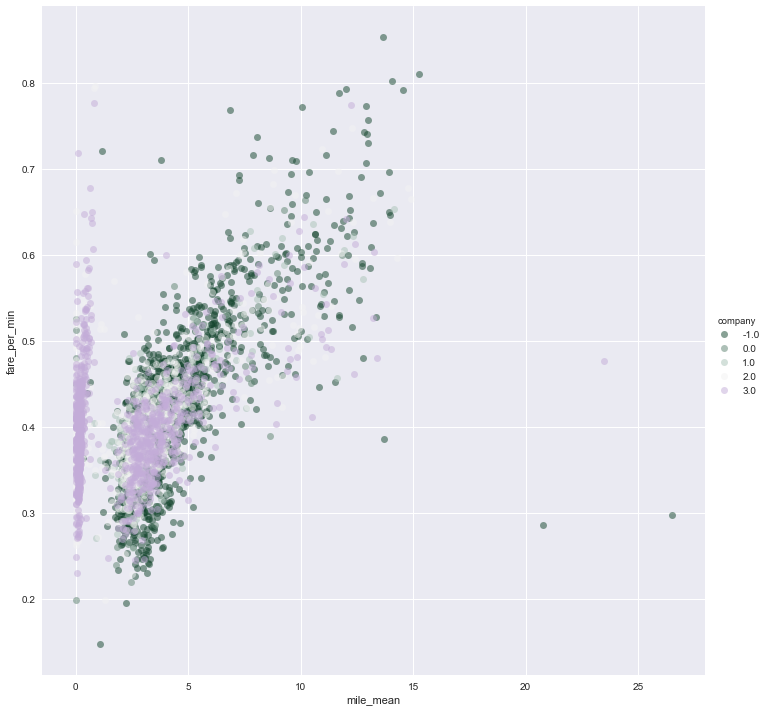

In [568]:
# Long trip or short trip
sns.lmplot(data=taxi_id2, x = 'mile_mean', y = 'fare_per_min', fit_reg = False, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(145, 280, s=85, l=25, n=7))
plt.show()

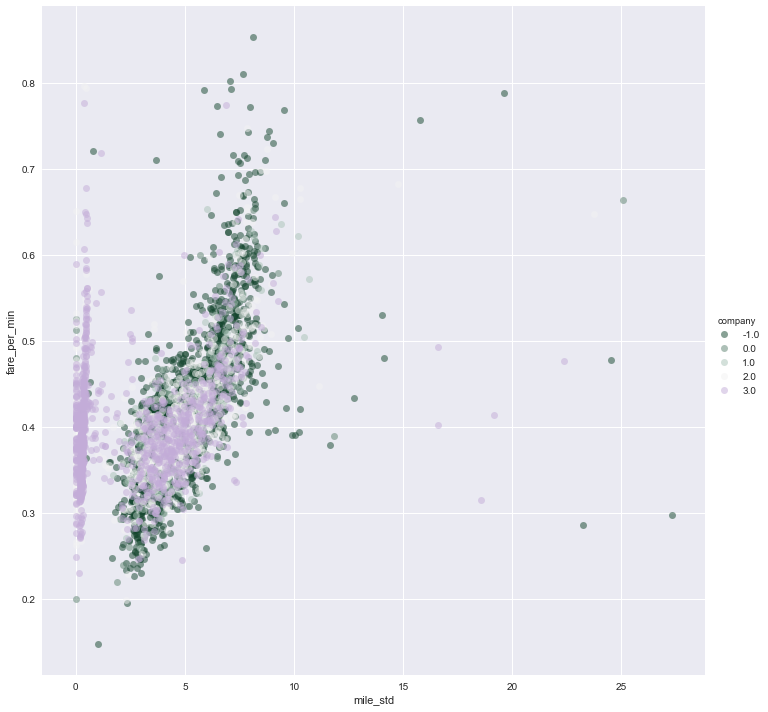

In [569]:
# How flexible you are to trip miles
sns.lmplot(data=taxi_id2, x = 'mile_std', y = 'fare_per_min', fit_reg = False, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(145, 280, s=85, l=25, n=7))
plt.show()

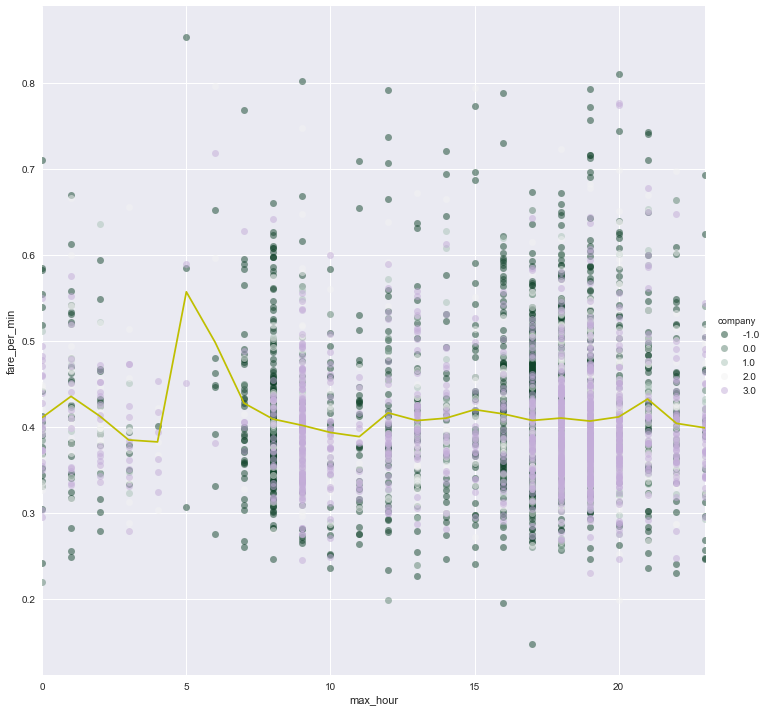

In [571]:
sns.lmplot(data=taxi_id2, x = 'max_hour', y = 'fare_per_min', fit_reg = False, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(145, 280, s=85, l=25, n=7))
max_hour_fare = taxi_id2.groupby('max_hour')['fare_per_min'].mean()
max_hour_fare.plot(color = 'y')
plt.show()

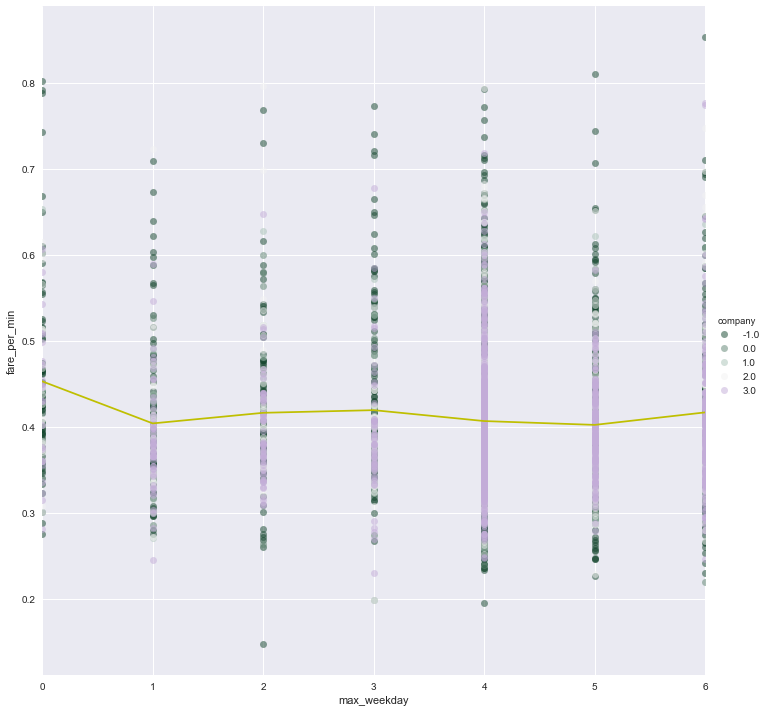

In [572]:
sns.lmplot(data=taxi_id2, x = 'max_weekday', y = 'fare_per_min', fit_reg = False, hue= 'company', size = 10, 
           scatter_kws={'alpha':0.5}, palette = sns.diverging_palette(145, 280, s=85, l=25, n=7))
max_hour_fare = taxi_id2.groupby('max_weekday')['fare_per_min'].mean()
max_hour_fare.plot(color = 'y')
plt.show()

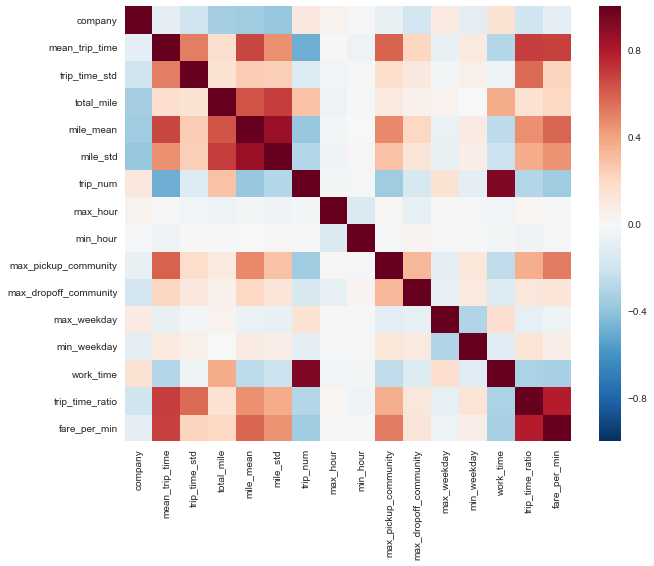

In [573]:
# Drop the 'total fare' and 'total_trip_time', which are closely related to the target and cannot be chosen by the driver.
taxi_id2.drop(['total_fare', 'total_trip_time'], axis = 1, inplace=True)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(taxi_id2.corr(), ax = ax)
plt.show()

In [574]:
taxi_id2.corr()['fare_per_min']

company                 -0.094264
mean_trip_time           0.681256
trip_time_std            0.224668
total_mile               0.206629
mile_mean                0.584965
mile_std                 0.448758
trip_num                -0.352432
max_hour                -0.008376
min_hour                -0.020346
max_pickup_community     0.520984
max_dropoff_community    0.131638
max_weekday             -0.051260
min_weekday              0.064771
work_time               -0.330868
trip_time_ratio          0.783261
fare_per_min             1.000000
Name: fare_per_min, dtype: float64

In [575]:
taxi_id2.isnull().sum()

company                  0
mean_trip_time           0
trip_time_std            0
total_mile               0
mile_mean                0
mile_std                 0
trip_num                 0
max_hour                 0
min_hour                 0
max_pickup_community     0
max_dropoff_community    0
max_route                0
max_weekday              0
min_weekday              0
work_time                0
trip_time_ratio          0
fare_per_min             0
dtype: int64

# Random Forest Regressor 

In [576]:
fare_per_min = taxi_id2['fare_per_min']
taxi_id2.drop('fare_per_min', axis = 1, inplace=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(taxi_id2, fare_per_min, test_size=0.33, random_state=42)

In [577]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = RandomForestRegressor(n_estimators = 50)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(mean_squared_error(pred, y_test))
print(r2_score(pred, y_test))


0.00079938305943
0.853395366923


                       feature_importance
max_dropoff_community            0.001800
max_weekday                      0.003818
company                          0.004038
max_route                        0.005023
min_weekday                      0.005372
min_hour                         0.006392
max_hour                         0.008288
trip_num                         0.009900
work_time                        0.010374
total_mile                       0.011426
trip_time_std                    0.031556
mile_std                         0.047668
mean_trip_time                   0.066869
mile_mean                        0.089267
max_pickup_community             0.090110
trip_time_ratio                  0.608099


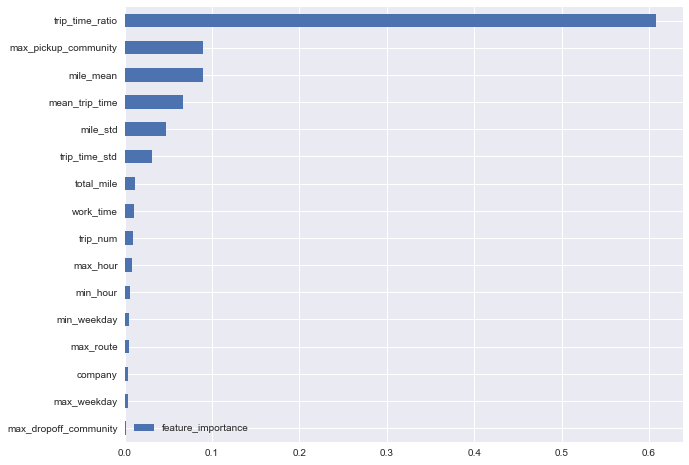

In [586]:
feature_importance = pd.DataFrame(model.feature_importances_)
feature_importance.index = taxi_id2.columns
feature_importance.columns = ['feature_importance']
feature_importance.sort_values(by='feature_importance', inplace=True)
print(feature_importance)
fig, ax = plt.subplots(figsize=(10, 8))
feature_importance.plot.barh(ax=ax)
plt.show()